In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re, string
#from textblob import TextBlob
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN

In [2]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
len(df_train)

159571

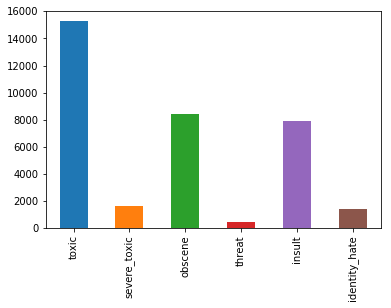

In [4]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_train[label_cols].sum().plot.bar()

In [5]:
df_train['category'] = df_train[label_cols].max(axis=1)

In [29]:
count_toxic = df_train['category'].sum()#df_train[df_train['category'] != 0].count     #.sum
count_toxic

162250

In [30]:
percentage_toxic = float(count_toxic)/len(df_train)
print(percentage_toxic*100)

53.09297242110499


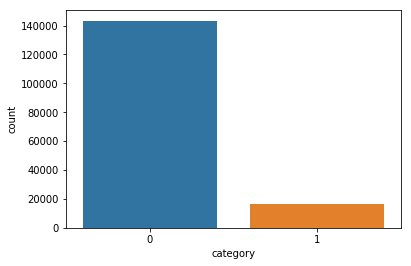

In [8]:
sns.countplot(df_train['category'])

As we can see, there are only 10% of toxic comments available in the training dataset. This shows class imbalance between non-toxic and toxic comments(which includes all labels)
So, let's try to increase the number of samples in toxic category and see the results.

In [9]:
df_train['comment_text'].notna().sum()

159571

In [10]:
df_train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
category         False
dtype: bool

Increasinng the sampling by appending the toxic comment back to training dataset

In [11]:
df_train_resample = df_train[df_train['category'] == 1]
df_train_resample.shape

(16225, 9)

In [12]:
df_train_resample.reset_index(drop=True, inplace=True)
df_train_resample.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
1,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
2,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,1
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1


In [28]:
df_train = pd.concat([df_train, df_train_resample])
df_train.shape

(305596, 9)

In [31]:
df_train.category.sum()

162250

In [32]:
df_train.shape

(305596, 9)

Let's implement the ML models now..

In [33]:
#Removing unecessary punctutation from the comments
re_tok = re.compile("([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [34]:
n = df_train.shape[0]
# sublinear_tf = True -> To use a logarithmic form of Frequency
# min_df = 3          -> minimum numbers of documents a word must be present in to be kept
# norm = l2           -> to ensure all our feature vectors have a euclidian norm of 1
# stop_words = 'english' -> As we're dealing with English comments, removing the stopwords for model to be efficient
vec = TfidfVectorizer( ngram_range=(1,1),       tokenizer=tokenize,
                       min_df=5,                max_df=0.9, 
                       strip_accents='unicode', use_idf=1,
                       smooth_idf=1,            sublinear_tf=1, 
                       norm = 'l2',             stop_words='english' )

In [35]:
train_features = vec.fit_transform(df_train['comment_text'])
test_features = vec.transform(df_test['comment_text'])

In [36]:
train_features.shape, test_features.shape

((305596, 12360), (153164, 12360))

In [37]:
model = LogisticRegression(C=4, dual=True)

In [38]:
predictions_df = np.zeros((len(df_test), len(label_cols)))
for i, col in enumerate(label_cols):
    print("fit: ", col)
    classifier = model.fit(train_features, df_train[col].values)
    predictions_df[:,i] = classifier.predict_proba(test_features)[:,1]
    #pred_df = pd.DataFrame(predictions)
    print(predictions_df.shape)

fit:  toxic
(153164, 6)
fit:  severe_toxic
(153164, 6)
fit:  obscene
(153164, 6)
fit:  threat
(153164, 6)
fit:  insult
(153164, 6)
fit:  identity_hate
(153164, 6)


In [39]:
for col in label_cols:
    accuracy = cross_val_score(model, train_features, df_train[col].values, scoring='accuracy', cv=5)
    print(col, ": ", accuracy.mean())

toxic :  0.8154164085550555
severe_toxic :  0.9591748406828702
obscene :  0.8509502206300146
threat :  0.9881641118060905
insult :  0.8403839553432327
identity_hate :  0.9653333119819726
